/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Epoch 1/10
Train Loss: 0.5533 | Acc: 0.5358 | F1: 0.5311
Val Metrics - Acc: 0.5860 | Prec: 0.5861 | Rec: 0.5860 | F1: 0.5859

Epoch 2/10
Train Loss: 0.4290 | Acc: 0.7193 | F1: 0.7172
Val Metrics - Acc: 0.5700 | Prec: 0.5703 | Rec: 0.5700 | F1: 0.5695

Epoch 3/10
Train Loss: 0.2540 | Acc: 0.8618 | F1: 0.8566
Val Metrics - Acc: 0.5460 | Prec: 0.5554 | Rec: 0.5460 | F1: 0.5259

Epoch 4/10
Train Loss: 0.1057 | Acc: 0.9539 | F1: 0.9507
Val Metrics - Acc: 0.5560 | Prec: 0.5714 | Rec: 0.5560 | F1: 0.5307

Epoch 5/10
Train Loss: 0.0345 | Acc: 0.9876 | F1: 0.9866
Val Metrics - Acc: 0.5760 | Prec: 0.5969 | Rec: 0.5760 | F1: 0.5519

Epoch 6/10
Train Loss: 0.0188 | Acc: 0.9939 | F1: 0.9934
Val Metrics - Acc: 0.5720 | Prec: 0.5926 | Rec: 0.5720 | F1: 0.5468

Epoch 7/10
Train Loss: 0.0117 | Acc: 0.9961 | F1: 0.9958
Val Metrics - Acc: 0.5800 | Prec: 0.5992 | Rec: 0.5800 | F1: 0.5586

Epoch 8/10
Train Loss: 0.0074 | Acc: 0.9979 | F1: 0.9977
Val Metrics - Acc: 0.5680 | Prec: 0.5902 | Rec: 0.5680 | F1:

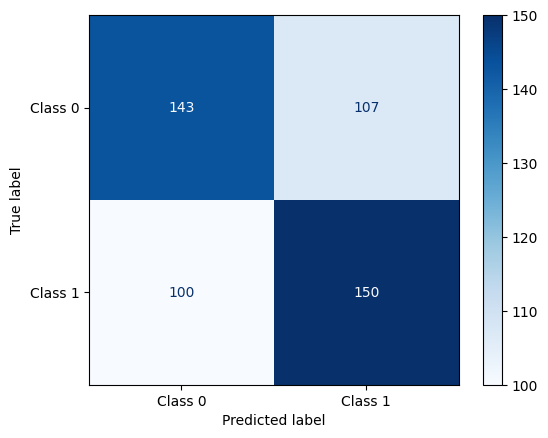

Predictions saved to final_predictions.csv


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from PIL import Image
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score,
                            classification_report,
                            ConfusionMatrixDisplay)
import glob
from torch.nn.utils.rnn import pad_sequence

# ====================
#  Configuration
# ====================
DATA_ROOT = "/content/drive/MyDrive/data/img1"
CSV_PATHS = {
    "train": os.path.join(DATA_ROOT, "train.csv"),
    "val": os.path.join(DATA_ROOT, "val.csv"),
    "test": os.path.join(DATA_ROOT, "test.csv")
}
IMAGE_DIR = os.path.join(DATA_ROOT, "img")
CHECKPOINT_DIR = "/content/drive/MyDrive/data/img1"

# Model parameters
TEXT_MAX_LEN = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10
LR = 2e-5
CLASS_WEIGHTS = [1.0, 4.0]

# ====================
#  Enhanced Dataset Class
# ====================
class MemeDataset(Dataset):
    def __init__(self, csv_path, img_dir, text_max_len=64, transform=None, has_labels=True):
        # Validate CSV existence
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"CSV file not found: {csv_path}")

        self.data = pd.read_csv(csv_path)

        # Validate required columns
        required_columns = ['img', 'text']
        if has_labels:
            required_columns.append('label')

        missing_cols = [col for col in required_columns if col not in self.data.columns]
        if missing_cols:
            raise KeyError(f"Missing columns in {csv_path}: {missing_cols}")

        # Clean and filter data
        self.data = self.data.dropna(subset=['img', 'text'])
        self.data = self.data[self.data['img'].apply(lambda x: isinstance(x, str))]
        self.data = self.data[self.data['text'].apply(lambda x: isinstance(x, str))]
        self.data.reset_index(drop=True, inplace=True)

        self.img_dir = img_dir
        self.has_labels = has_labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.text_max_len = text_max_len
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])

    def __getitem__(self, idx):
        try:
            row = self.data.iloc[idx]

            # Process image path
            img_filename = os.path.basename(str(row['img']).strip())
            img_path = os.path.join(self.img_dir, img_filename)

            if not os.path.isfile(img_path):
                raise FileNotFoundError(f"Image file missing: {img_path}")

            image = Image.open(img_path).convert('RGB')

            # Process text
            text = str(row['text']).strip()
            if len(text) == 0:
                raise ValueError("Empty text field")

            # Tokenization
            inputs = self.tokenizer(
                text,
                max_length=self.text_max_len,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            item = {
                'image': self.transform(image),
                'input_ids': inputs['input_ids'].squeeze(0),
                'attention_mask': inputs['attention_mask'].squeeze(0),
            }

            if self.has_labels:
                label = int(row['label'])
                if label not in [0, 1]:
                    raise ValueError(f"Invalid label value: {label}")
                item['label'] = torch.tensor(label, dtype=torch.long)

            return item

        except Exception as e:
            print(f"Error processing index {idx}: {str(e)}")
            return None

    def __len__(self):
        return len(self.data)

# ====================
#  Custom Collate Function
# ====================
def custom_collate(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None

    elem = batch[0]
    collated = {}

    for key in elem:
        if key == 'label':
            collated[key] = torch.stack([d[key] for d in batch])
        else:
            collated[key] = torch.stack([d[key] for d in batch])

    return collated

# ====================
#  Model Architecture
# ====================
class MultiModalModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        resnet = torchvision.models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])

        # Projection layers
        self.img_proj = nn.Linear(2048, 768)
        self.text_proj = nn.Linear(768, 768)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(768*2, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # Text features
        text_out = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        text_features = text_out.last_hidden_state[:, 0, :]

        # Image features
        img_features = self.resnet(image).flatten(1)
        img_features = self.img_proj(img_features)

        # Combine features
        combined = torch.cat([text_features, img_features], dim=1)
        return self.classifier(combined)

# ====================
#  Training Setup
# ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(CLASS_WEIGHTS).to(device))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

# ====================
#  Training Loop
# ====================
def calculate_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='macro'),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'f1': f1_score(y_true, y_pred, average='macro')
    }

best_val_f1 = 0
for epoch in range(NUM_EPOCHS):
    # Training Phase
    model.train()
    train_preds, train_labels, train_loss = [], [], 0.0

    train_loader = DataLoader(
        MemeDataset(CSV_PATHS["train"], IMAGE_DIR, TEXT_MAX_LEN, has_labels=True),
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=custom_collate,
        num_workers=2
    )

    for batch in train_loader:
        if batch is None:
            continue

        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
        labels = batch['label'].to(device)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(torch.argmax(outputs.detach().cpu(), 1).numpy())
        train_labels.extend(labels.detach().cpu().numpy())

    # Validation Phase
    model.eval()
    val_preds, val_labels = [], []
    val_loader = DataLoader(
        MemeDataset(CSV_PATHS["val"], IMAGE_DIR, TEXT_MAX_LEN, has_labels=True),
        batch_size=BATCH_SIZE,
        collate_fn=custom_collate,
        num_workers=2
    )

    with torch.no_grad():
        for batch in val_loader:
            if batch is None:
                continue

            inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
            outputs = model(**inputs)

            val_preds.extend(torch.argmax(outputs.cpu(), 1).numpy())
            val_labels.extend(batch['label'].cpu().numpy())

    # Calculate metrics
    train_metrics = calculate_metrics(train_labels, train_preds)
    val_metrics = calculate_metrics(val_labels, val_preds)
    avg_train_loss = train_loss / len(train_loader)

    # Update scheduler
    scheduler.step(val_metrics['f1'])

    # Epoch Report
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f} | Acc: {train_metrics['accuracy']:.4f} | F1: {train_metrics['f1']:.4f}")
    print(f"Val Metrics - Acc: {val_metrics['accuracy']:.4f} | Prec: {val_metrics['precision']:.4f} | Rec: {val_metrics['recall']:.4f} | F1: {val_metrics['f1']:.4f}")

    # Save best model
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "best_model.pth"))

# ====================
#  Final Evaluation
# ====================
model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, "best_model.pth"), map_location=device))
model.eval()

val_loader = DataLoader(
    MemeDataset(CSV_PATHS["val"], IMAGE_DIR, TEXT_MAX_LEN, has_labels=True),
    batch_size=BATCH_SIZE,
    collate_fn=custom_collate,
    num_workers=2
)

final_preds, final_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        if batch is None:
            continue

        inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
        outputs = model(**inputs)

        final_preds.extend(torch.argmax(outputs.cpu(), 1).numpy())
        final_labels.extend(batch['label'].cpu().numpy())

# Generate final report
print("\n\033[1mFinal Validation Report:\033[0m")
print(classification_report(final_labels, final_preds, target_names=['Class 0', 'Class 1']))
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(final_labels, final_preds,
                                      display_labels=['Class 0', 'Class 1'],
                                      cmap=plt.cm.Blues)
plt.show()

# Save predictions
val_df = pd.read_csv(CSV_PATHS["val"])
val_df['prediction'] = final_preds
val_df.to_csv(os.path.join(DATA_ROOT, "final_predictions.csv"), index=False)
print("Predictions saved to final_predictions.csv")

In [ ]:
print("Train data info:")
print(pd.read_csv(CSV_PATHS["train"]).info())

print("\nValidation data info:")
print(pd.read_csv(CSV_PATHS["val"]).info())

Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8500 non-null   int64 
 1   img     8500 non-null   object
 2   label   8500 non-null   int64 
 3   text    8500 non-null   object
dtypes: int64(2), object(2)
memory usage: 265.8+ KB
None

Validation data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      500 non-null    int64 
 1   img     500 non-null    object
 2   label   500 non-null    int64 
 3   text    500 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.8+ KB
None


In [ ]:
def check_paths(csv_path):
    df = pd.read_csv(csv_path)
    missing = 0
    for idx, row in df.iterrows():
        path = os.path.join(IMAGE_DIR, os.path.basename(row['img']))
        if not os.path.isfile(path):
            missing += 1
    print(f"Missing {missing}/{len(df)} images in {csv_path}")

check_paths(CSV_PATHS["train"])
check_paths(CSV_PATHS["val"])

Missing 0/8500 images in /content/drive/MyDrive/data/img1/train.csv
Missing 0/500 images in /content/drive/MyDrive/data/img1/val.csv
